# Классификация новостей с помощью Embedding нейросети

In [ ]:
# Для нейросети
from tensorflow.keras import utils # Для работы с категориальными данными
from tensorflow.keras.models import Sequential # Полносвязная модель
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Flatten, Activation, Embedding # Слои для сети
from tensorflow.keras.preprocessing.text import Tokenizer # Методы для работы с текстами
from tensorflow.keras.preprocessing.sequence import pad_sequences # Метод для работы с последовательностями

from google.colab import drive # Для работы с Google Drive
from google.colab import files # Для работы с файлами 
import numpy as np # Для работы с данными 
import matplotlib.pyplot as plt # Для вывода графиков
import os # Для работы с файлами
%matplotlib inline

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Удаляем директорию с распакованными данными (если есть)
!rm -rf /content/news

In [ ]:
!unzip -q '/content/drive/MyDrive/Colab Notebooks/Machine_learning/Datasets/news.zip' -d /content/

In [ ]:
# Функция для загрузки файла
def loadText(fileName):
  f = open(fileName, 'r') # Открываем файл в режиме чтения
  text = f.read()         # Читаем текст
  text = text.replace("\n", " ") # Заменяем переносы строк на пробелы
  text = text.replace("\r", " ") # Заменяем переносы строк на пробелы
  text = text.replace("\t", " ") # Заменяем табуляции на пробелы
  f.close()
  
  return text

labels = ["Политика", "Спорт", "Технологии"] # Классифицируемые новости
labelsNum = len(labels) # Количество классифицируемых групп

In [ ]:
# Загружаем тексты из обучающей и тренировочной выборок

trainText = [] # Обучающие тексты
testText = []  # Тестовые тексты

fileList = os.listdir('news/') # Получаем список всех файлов
for label in labels:
  for file in fileList:
    if label in file: # Проверяем, содержит ли файл j в названии имя класса i
      if 'Обучающая' in file: # Если в имени найденного класса есть строка "Обучающая" 
        trainText.append(loadText('news/' + file)) #добавляем в обучающую выборку
        print(file, 'добавлен в обучающую выборку')
      if 'Тестовая' in file: # Если в имени найденного класса есть строка "Тестовая"
        testText.append(loadText('news/' + file)) # Добавляем в обучающую выборку
        print(file, 'добавлен в тестовую выборку')

Политика Обучающая.txt добавлен в обучающую выборку
Политика Тестовая.txt добавлен в тестовую выборку
Спорт Обучающая.txt добавлен в обучающую выборку
Спорт Тестовая.txt добавлен в тестовую выборку
Технологии Тестовая.txt добавлен в тестовую выборку
Технологии Обучающая.txt добавлен в обучающую выборку


In [ ]:
print("Количество загруженных обучающих текстов:", len(trainText))
print("Количество загруженных тестовых текстов:", len(testText))

Количество загруженных обучающих текстов: 3
Количество загруженных тестовых текстов: 3


Токенизируем тексты

In [ ]:
numWords = 20000 # Количество слов/индексов, которое мы будем учитывать при обучении

# Tokenizer - встроенная в Keras функция для разбиения текста и превращения
# в слов в числовые значения с учётом частотности

# num_words - максимальное количество слов/индексов, учитываемое при составлении словаря
# filters - список ненужных символов, которые будут удалены из текстов
# lower - приведение слов к нижнему регистру
# split - разделитель между словами
# oov_token - на какое слово будем заменять слова, которые выше по частоте, чем numWords
# char_level - разбитие по буквам или по словам

tokenizer = Tokenizer(num_words=numWords,
                      filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
                      lower=True,
                      split=' ',
                      oov_token='unknown',
                      char_level=False)

tokenizer.fit_on_texts(trainText) # Cоберем словарь частотности
items = list(tokenizer.word_index.items()) # Получаем индексы слов

In [ ]:
print("Самые часто встречающиеся слова:")
print(items[:10]) # Самые часто встречающиеся слова
print()
print("Самые редко встречающиеся слова:")
print(items[-10:])
print()
print("Размер словаря:", len(items))

Самые часто встречающиеся слова:
[('unknown', 1), ('в', 2), ('и', 3), ('на', 4), ('с', 5), ('не', 6), ('что', 7), ('по', 8), ('за', 9), ('для', 10)]

Самые редко встречающиеся слова:
[('ming', 69837), ('chi', 69838), ('kuo', 69839), ('исчезут', 69840), ('начальную', 69841), ('воссоздали', 69842), ('sanktperkele', 69843), ('встроенного', 69844), ('достоверно', 69845), ('подошёл', 69846)]

Размер словаря: 69846


In [ ]:
# # Тестирование словаря
# inputWord = input("Введите слово: ")
# print("Индекс слова ",inputWord, ": ", tokenizer.word_index[inputWord])

In [ ]:
# Преобразовываем текст в последовательность индексов согласно частотному словарю
trainWordIndexes = tokenizer.texts_to_sequences(trainText)
testWordIndexes = tokenizer.texts_to_sequences(testText)

In [ ]:
# Проверим преобразование
print("Фрагмент обучающего текста:")
print("В виде оригинального текста:              ", trainText[2][:23])
print("Он же в виде последовательности индексов: ", trainWordIndexes[0][:5], '\n')

Фрагмент обучающего текста:
В виде оригинального текста:                Софт и игры Обзор Part
Он же в виде последовательности индексов:  [143, 49, 99, 164, 136] 



In [ ]:
print("Статистика по обучающим текстам:")

symbolsTrainText = 0 # Объявляем переменную для подсчета символов в обучающих текстах
wordsTrainText = 0 # Объявляем переменную для подсчета слов в обучающих текстах

for i in range(labelsNum): # Проходим по всем классам
  print(labels[i], " "*(10-len(labels[i])), len(trainText[i]), "символов, ", len(trainWordIndexes[i]), "слов")
  symbolsTrainText += len(trainText[i]) # Считаем символы
  wordsTrainText += len(trainWordIndexes[i]) # Считаем слова 

print('----')
print("В сумме ", symbolsTrainText, " символов, ", wordsTrainText, " слов \n")
print()
print("Статистика по тестовым текстам:")

symbolsTestText = 0 # Объявляем переменную для подсчета символов в тестовых текстах
wordsTestText = 0 # Объявляем переменную для подсчета слов в тестовых текстах

for i in range(labelsNum): #Проходим по всем классам
  print(labels[i], ' '*(10-len(labels[i])), len(testText[i]), "символов, ", len(testWordIndexes[i]), "слов")
  symbolsTestText += len(testText[i]) #Считаем символы
  wordsTestText += len(testWordIndexes[i]) #Считаем слова 
print('----')
print("В сумме ", symbolsTestText, " символов, ", wordsTestText, " слов")

Статистика по обучающим текстам:
Политика    1744978 символов,  238065 слов
Спорт       1808908 символов,  262022 слов
Технологии  1779783 символов,  253146 слов
----
В сумме  5333669  символов,  753233  слов 


Статистика по тестовым текстам:
Политика    197551 символов,  26851 слов
Спорт       169031 символов,  24435 слов
Технологии  186296 символов,  26250 слов
----
В сумме  552878  символов,  77536  слов


Создаем xTrain и yTrain

In [ ]:
# Формирование обучающей выборки по листу индексов слов
# путем разделения на короткие векторы
# wordIndexes - массив индексов
# xLen - размер окна
# step - шаг окна
def getSetFromIndexes(wordIndexes, xLen, step):
  xText = []
  wordsLen = len(wordIndexes) # Считаем количество слов
  index = 0 # Задаем начальный индекс 

  while (index + xLen <= wordsLen): # Идём по всей длине вектора индексов
    xText.append(wordIndexes[index:index+xLen]) # "Откусываем" векторы длины xLen
    index += step # Смещаеммся вперёд на step
    
  return xText


# Формирование обучающей и проверочной выборки для каждого класса
# wordIndexes - массив индексов
# xLen - размер окна
# step - шаг окна
def createSetsMultiClasses(wordIndexes, xLen, step): # Функция принимает последовательность индексов, размер окна, шаг окна
  nClasses = len(wordIndexes) # Количество классов
  classesXSamples = []        # Здесь будет список размером "кол-во классов*кол-во окон в тексте*длину окна (например, 6 по 1341*1000)"
  for wI in wordIndexes:      # Для каждого текста выборки из последовательности индексов
    classesXSamples.append(getSetFromIndexes(wI, xLen, step))

  # Формируем один общий xSamples
  xSamples = []
  ySamples = []
  
  for t in range(nClasses):
    xT = classesXSamples[t]
    for i in range(len(xT)): # Перебираем каждое окно определенного класса
      xSamples.append(xT[i]) # Добавляем в общий список выборки
      ySamples.append(utils.to_categorical(t, nClasses)) # Добавляем соответствующий вектор класса

  xSamples = np.array(xSamples)
  ySamples = np.array(ySamples)

  
  return (xSamples, ySamples)

In [ ]:
# Задаём базовые параметры
xLen = 500 # Размер окна (количество слов в векторе)
step = 60 # Шаг разбиения текста на векторы

In [ ]:
# Формируем обучающую и тестовую выборку
xTrainId, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step)
xTestId, yTest = createSetsMultiClasses(testWordIndexes, xLen, xLen)
print("Размерности тренировочного набора")
print(xTrainId.shape)
print(yTrain.shape)
print()
print("Размерности тестового набора")
print(xTestId.shape)
print(yTest.shape)

Размерности тренировочного набора
(12530, 500)
(12530, 3)

Размерности тестового набора
(153, 500)
(153, 3)


In [ ]:
print(xTrainId[0])

[  143    49    99   164   136    24   162   145   102     2  6658   106
   878    81  3074  2061     5   390    99  1751   666     2  1266  3074
   440     5   390   342  1027   747  5887  1785   106  1232     1     2
  2205     4  1644     2  1926   477  1362     4  2005     4 10642    20
    20    43    90  1751  6659     2  1266  3074   440     5   390   147
 13353  4641    11  2767     6     1     1     1     5 15446     4   706
   147  1563     1     1  2688     8     1   350    29    65    62  2311
    28    10    95    61    43    54    82     1     4   523   120   782
   266    25   150   178  1267  4240  2557     8  2897  1785     3     1
 10643  5596   234 13354  2108     5 18063     7    49 13355  1006   924
     4   706    11  2767     4   817   274 18064 10644    44    46  2612
  6660     3     1  1051  2767     6 18065   485   612  8187     7    49
     6 18066  1006    19    65   620  1588     2   401     5     1  4439
     5   306   221    49     5    20   108  9621  2

In [ ]:
# Не преобразуем в Bag Of Words

# xTrain  = tokenizer.sequences_to_matrix(xTrainId.tolist())
# xTest  = tokenizer.sequences_to_matrix(xTestId.tolist())

xTrain = xTrainId
xTest  = xTestId

print("Размерность обучайющей выборки")
print(xTrain.shape)
print(yTrain.shape)

print()

print("Размерность тестовой выборки")
print(xTest.shape)
print(yTest.shape)


Размерность обучайющей выборки
(12530, 500)
(12530, 3)

Размерность тестовой выборки
(153, 500)
(153, 3)


Нейросеть для классификации текстов на базе Embedding

In [ ]:
# Создаём полносвязную сеть
model = Sequential()
model.add(Embedding(numWords, 10, input_length=xLen))
model.add(SpatialDropout1D(0.20))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 10)           200000    
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 500, 10)          0         
 lDropout1D)                                                     
                                                                 
 flatten_1 (Flatten)         (None, 5000)              0         
                                                                 
 batch_normalization_1 (Batc  (None, 5000)             20000     
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 3)                 15003     
                                                                 
Total params: 235,003
Trainable params: 225,003
Non-tr

In [ ]:
# Обучаем сеть
history = model.fit(xTrain, 
                    yTrain, 
                    epochs=20,
                    batch_size=64,
                    validation_split=0.2)

Epoch 1/20
157/157 [==============================] - 4s 10ms/step - loss: 0.3674 - accuracy: 0.8423 - val_loss: 1.0926 - val_accuracy: 0.0982
Epoch 2/20
157/157 [==============================] - 1s 9ms/step - loss: 0.0053 - accuracy: 0.9996 - val_loss: 0.7447 - val_accuracy: 0.8819
Epoch 3/20
157/157 [==============================] - 1s 8ms/step - loss: 0.0032 - accuracy: 0.9996 - val_loss: 0.1538 - val_accuracy: 0.9992
Epoch 4/20
157/157 [==============================] - 1s 8ms/step - loss: 0.0023 - accuracy: 0.9998 - val_loss: 0.0108 - val_accuracy: 1.0000
Epoch 5/20
157/157 [==============================] - 1s 8ms/step - loss: 0.0019 - accuracy: 0.9996 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 6/20
157/157 [==============================] - 1s 8ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 7/20
157/157 [==============================] - 1s 8ms/step - loss: 0.0013 - accuracy: 0.9997 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch

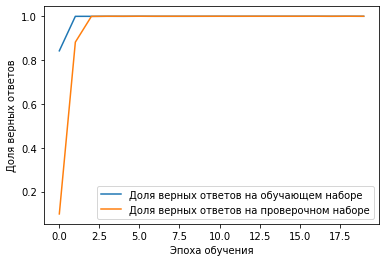

In [ ]:
# Результаты обучения
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

Проверяем работу обученной нейросети

In [ ]:
# Проверяем точность на тестовой выборке

rightAnswer = [0,0,0,0,0,0]
totalAnswer = [0,0,0,0,0,0]

# Получаем результаты распознавания для каждого класса
currPred = model.predict(xTest)
# Определяем номер распознанного класса для каждохо вектора
currOut = np.argmax(currPred, axis=1)
# Определяем правильный класс для каждохо вектора
yOut = np.argmax(yTest, axis=1)

print(currPred.shape)
print(currOut.shape)
print(yOut.shape)
print()


# Считаем сколько ответов всего и сколько из них правильных
for i in range(len(yOut)):
  predictA = currOut[i]
  rightA   = yOut[i]

  totalAnswer[rightA] += 1
  if predictA == rightA:
    rightAnswer[rightA] += 1

# Подсчитываем точность классификации
print("Точность распознавания текстов писателей")
for i in range(labelsNum):
  print("{:12s}: {:3d} из {:3d} - {:3.2f}%".format(labels[i], rightAnswer[i], totalAnswer[i], (rightAnswer[i]/totalAnswer[i]*100)))

(153, 3)
(153,)
(153,)

Точность распознавания текстов писателей
Политика    :  53 из  53 - 100.00%
Спорт       :  48 из  48 - 100.00%
Технологии  :  52 из  52 - 100.00%
